In [1]:
import numpy as np
import pandas as pd
import os

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from string import punctuation

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC

from xgboost import XGBClassifier

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Getting the data 

Download data and look at the top 5 records

In [3]:
df = pd.read_csv(os.path.join('datasets', 'bbc-text.csv'))
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
category    2225 non-null object
text        2225 non-null object
dtypes: object(2)
memory usage: 34.9+ KB


Look at the categories distributuon

In [5]:
df['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

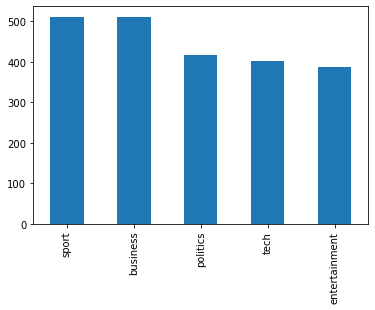

In [6]:
df['category'].value_counts().plot.bar()

Encode categories into labels

In [7]:
le = LabelEncoder()
df['labels'] = le.fit_transform(df['category'])
df.head()

,category,text,labels
0,tech,tv future in the hands of viewers with home th...,4
1,business,worldcom boss left books alone former worldc...,0
2,sport,tigers wary of farrell gamble leicester say ...,3
3,sport,yeading face newcastle in fa cup premiership s...,3
4,entertainment,ocean s twelve raids box office ocean s twelve...,1


Tokenize texts, stem and remove punctuation and stopwords

In [8]:
stemmer = PorterStemmer()
to_exclude = set(stopwords.words('english') + list(punctuation))
filter_func = lambda text: ' '.join([stemmer.stem(word) for word in word_tokenize(text) if word not in to_exclude])

In [9]:
df['text'] = df['text'].apply(filter_func)
df.head()

,category,text,labels
0,tech,tv futur hand viewer home theatr system plasma...,4
1,business,worldcom boss left book alon former worldcom b...,0
2,sport,tiger wari farrel gambl leicest say rush make ...,3
3,sport,yead face newcastl fa cup premiership side new...,3
4,entertainment,ocean twelv raid box offic ocean twelv crime c...,1


## Bag of words 

Getting features

In [10]:
vect = CountVectorizer()
X_bw = vect.fit_transform(df['text'].values)
y = df['labels'].values

print('X shape: {}, y shape: {}'.format(X_bw.shape, y.shape))

X shape: (2225, 20968), y shape: (2225,)


### Random Forest 

Creating the model & look at the params

In [11]:
rfc = RandomForestClassifier(random_state=1, n_jobs=-1)
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

We will use GridSearch to find the best model

In [12]:
rf_grid = {
    'n_estimators': np.linspace(100, 1000, 8).astype(int),
    'max_depth': [None] + list(np.linspace(5, 100, 6))
}

Creating cross-validation strategy

In [13]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [14]:
rf_grid_search_estimator = GridSearchCV(rfc, rf_grid, scoring='accuracy', cv=cv, n_jobs=-1)
rf_grid_search_estimator.fit(X_bw, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              o

Look at the best params and score (accuracy)

In [15]:
rf_grid_search_estimator.best_params_

{'max_depth': 24.0, 'n_estimators': 871}

In [16]:
print('BoW RF best score: {:.8f}'.format(rf_grid_search_estimator.best_score_))

BoW RF best score: 0.96719101


### SVM 

In [17]:
svc = SVC(random_state=1)
svc.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [18]:
svc_grid = {
    'kernel': ['poly', 'rbf', 'sigmoid', 'linear']
}

In [19]:
svc_grid_search_estimator = GridSearchCV(svc, svc_grid, scoring='accuracy', cv=cv, n_jobs=-1)
svc_grid_search_estimator.fit(X_bw, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=1, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'kernel': ['poly', 'rbf', 'sigmoid', 'linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [20]:
svc_grid_search_estimator.best_params_

{'kernel': 'sigmoid'}

In [21]:
print('BoW SVM best score: {:.8f}'.format(svc_grid_search_estimator.best_score_))

BoW SVM best score: 0.97258427


## Tf-idf 

Getting features

In [22]:
tf_vect = TfidfVectorizer(ngram_range=(1, 2))
X_tf = tf_vect.fit_transform(df['text'].values)
y = df['labels'].values

print('X shape: {}, y shape: {}'.format(X_tf.shape, y.shape))

X shape: (2225, 338953), y shape: (2225,)


### Random Forest 

In [23]:
rf_grid_search_estimator.fit(X_tf, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              o

In [24]:
rf_grid_search_estimator.best_params_

{'max_depth': None, 'n_estimators': 485}

Best parameters have changed comparing to BoW model

In [25]:
print('TF-IDF RF best score: {:.8f}'.format(rf_grid_search_estimator.best_score_))

TF-IDF RF best score: 0.96314607


### SVM 

In [26]:
svc_grid_search_estimator.fit(X_tf, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=1, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'kernel': ['poly', 'rbf', 'sigmoid', 'linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [27]:
svc_grid_search_estimator.best_params_

{'kernel': 'sigmoid'}

Sigmoid kernel still is the best kernel

In [28]:
print('TF-IDF SVM best score: {:.8f}'.format(svc_grid_search_estimator.best_score_))

TF-IDF SVM best score: 0.98067416
